## Cox Regression Experiments: Stratify by Race Group

### Load and Preprocess the Data

In [1]:
# import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index

In [2]:
# run notebook containing function that evaluates
# predictions using the stratified concordance index
%run -i ../examples/concordance_index.ipynb

In [3]:
# Load training data
hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop year column, which isn't appropriate for prediction
hct_df = hct_df.drop(columns=['year_hct'])

In [4]:
# Use one-hot encoding to encode categorical columns.
# The min_frequency option will bin very rare values
# of each categorical variable into a new
# 'infrequent' category.
# The minimum frequency of 0.001 corresponds to a 
# minimum of roughly 20 training samples.

cat_cols = list(hct_df.select_dtypes(include='O').columns)
cat_cols.remove('race_group')

encoder = ColumnTransformer(
    [
        ('one_hot', 
         OneHotEncoder(drop='first', 
                       min_frequency=0.001, 
                       handle_unknown='ignore',
                       ), 
        cat_cols
        ),
        ('ordinal',
         OrdinalEncoder(),
        ['race_group']
        )
    ],
    sparse_threshold=0,
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
    )

# Drop the ID column, which should not be used
# in prediction.
# We keep it in hct_df above, because it may 
# be needed for the custom score function.
df_enc = pd.DataFrame(encoder.fit_transform(hct_df), 
                      columns=encoder.get_feature_names_out()).drop("ID", axis=1)

### Fit a Cox Models with All Features

In [5]:
# Convenience function to create a pipeline
# the scales a passed-in list of numeric features,
# then uses a KNN-imputer to impute missing data.

from sklearn.compose import make_column_selector as selector

def create_pipeline(to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']):
    pipeline = Pipeline(
        [
            (
                "scale",
                ColumnTransformer(
                    [
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
            "impute",
            KNNImputer()
            )
        ],
        verbose=True
    )

    return pipeline

In [6]:
def get_result_by_race(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'

    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    score_dict = {}
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        score_dict[race] = c_index_race
    return score_dict

In [7]:
# Perform five-fold cross validation using 
# an out-of-the-box Cox model on the encoded features.

feat_names = df_enc.columns[:-2].to_list()
no_race_gp = feat_names.copy()
no_race_gp.remove('race_group')
target_names = ['efs', 'efs_time']

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
c_indexes = np.zeros(n_splits)
scores = np.zeros(n_splits)
results_dicts = []

from lifelines import CoxPHFitter

for num, (train_idx, test_idx) in enumerate(kfold.split(df_enc)):
    print("Now starting fold {}".format(num))
    
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]
    
    # Fit a pipeline to the training set for this split,
    # so that scaling and imputation are performed based
    # on the training data for this split only.
    pipeline = create_pipeline()


    X_train_proc = pd.concat([pd.DataFrame(pipeline.fit_transform(train[no_race_gp]), 
                            columns=pipeline.get_feature_names_out()).set_index(train_idx),
                            train.race_group], axis=1)
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    
    X_test_proc = pd.concat([pd.DataFrame(pipeline.transform(test[no_race_gp]), 
                            columns=pipeline.get_feature_names_out()).set_index(test_idx),
                            test.race_group], axis=1)        
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs', strata=['race_group'])
    
    # Partial hazards from the Cox Proportional Hazard
    # model can be used as a risk score for an individaul
    preds = cph.predict_partial_hazard(test_proc)

    # Use custome scoring functions to evaluate model predictions
    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")
    c_indexes[num] = concordance_index(y_test_proc['efs_time'], -preds, y_test_proc['efs'])
    results_dicts.append(get_result_by_race(solution.copy(deep=True), prediction.copy(deep=True), "ID"))

Now starting fold 0
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=  50.9s
Now starting fold 1
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=  50.5s
Now starting fold 2
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=  49.8s
Now starting fold 3
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=  49.9s
Now starting fold 4
[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total=  49.7s


In [8]:
# Print ordinary c-index for each run
print(c_indexes)

# Print stratified concordance index for each run
print(scores)

[0.67458218 0.6711193  0.66786282 0.66502382 0.66827877]
[0.66314277 0.65646564 0.65201503 0.65444626 0.64681272]


In [9]:
# Find the average score for all splits
# in our five-fold cross-validations
np.mean(scores)

np.float64(0.6545764827473516)

In [10]:
print(np.mean(c_indexes))

0.6693733791668642


In [11]:
results_by_race = pd.DataFrame(results_dicts)
results_by_race.describe()

,American Indian or Alaska Native,Asian,Black or African-American,More than one race,Native Hawaiian or other Pacific Islander,White
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.670631,0.684730,0.661543,0.675970,0.664588,0.651280
std,0.007498,0.010131,0.006814,0.009098,0.016397,0.010866
min,0.663912,0.675026,0.653405,0.665076,0.636313,0.638738
25%,0.667195,0.678452,0.656660,0.672335,0.666631,0.646649
50%,0.667406,0.678960,0.663227,0.675246,0.668097,0.649668
75%,0.671491,0.693725,0.663436,0.677175,0.675147,0.653111
max,0.683152,0.697487,0.670989,0.690014,0.676753,0.668237


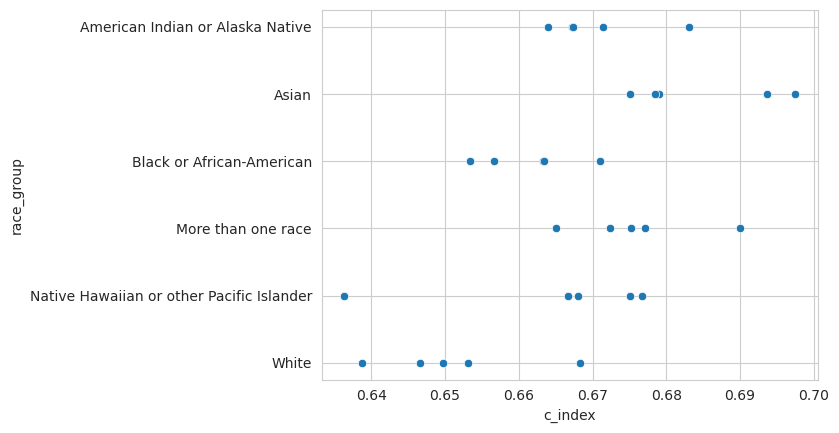

In [12]:
# Scatterplot of accuracy for each race group
# across 5-fold cross validation
results_by_race = pd.DataFrame(results_dicts)
to_plot = results_by_race.melt()
to_plot = to_plot.rename(columns={"variable":"race_group", "value":"c_index"})
sns.scatterplot(to_plot, y='race_group', x='c_index')
plt.show()

In [25]:
# Now try fitting the model on the entire training set.
pipeline = create_pipeline()

X_train_proc = pd.concat([pd.DataFrame(pipeline.fit_transform(df_enc[no_race_gp]), 
                                      columns=pipeline.get_feature_names_out()),
                                      df_enc.race_group], axis=1)
y_train_proc = df_enc[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

cph = CoxPHFitter()

cph.fit(train_proc, duration_col='efs_time', event_col='efs', strata=['race_group', 'donor_related_Unrelated'])

[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing impute, total= 1.1min


<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [28]:
# Examine model metrics and coefficients
# for the cox model fit on the entire 
# training set.
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                   strata = ['race_group', 'donor_related_Unrelated']
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -87600.22
         time fit was run = 2025-04-08 03:14:15 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.04      1.04      0.01            0.02            0.06                1.02                1.06
age_at_hct                                                   0.03      1.03      0.01            0.01            0.06                1.01                1.06
karnofsky_score                                             -0.06      0.94      0.01           -0.08           -0.04                0.92                0.96
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.05           -0.45           -0.27                0.64                0.76
dri_score_Intermediate                                      -0.44      0.64      0.03           -0.50           -0.39                0.61                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.34      0.71      0.07           -0.48           -0.19                0.62                0.82
dri_score_Low                                               -0.35      0.71      0.04           -0.42           -0.27                0.65                0.77
dri_score_N/A - disease not classifiable                    -0.48      0.62      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.69      0.04           -0.46           -0.29                0.63                0.75
dri_score_N/A - pediatric                                   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.82
dri_score_Very high                                         -0.23      0.80      0.13           -0.48            0.03                0.62                1.03
dri_score_nan                                               -0.63      0.53      0.13           -0.90           -0.37                0.41                0.69
psych_disturb_Not done                                       0.01      1.01      0.13           -0.25            0.26                0.78                1.30
psych_disturb_Yes                                            0.03      1.03      0.03           -0.02            0.09                0.98                1.09
psych_disturb_nan                                            0.10      1.10      0.06           -0.01            0.21                0.99                1.23
cyto_score_Intermediate                                      0.14      1.15      0.04            0.07            0.20                1.07                1.23
cyto_score_Normal                                            0.24      1.27      0.07            0.11            0.37                1.12                1.44
cyto_score_Not tested                                        0.04      1.04      0.20           -0.36            0.44                0.70                1.55
cyto_score_Other                                             0.25      1.28      0.07            0.10            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03

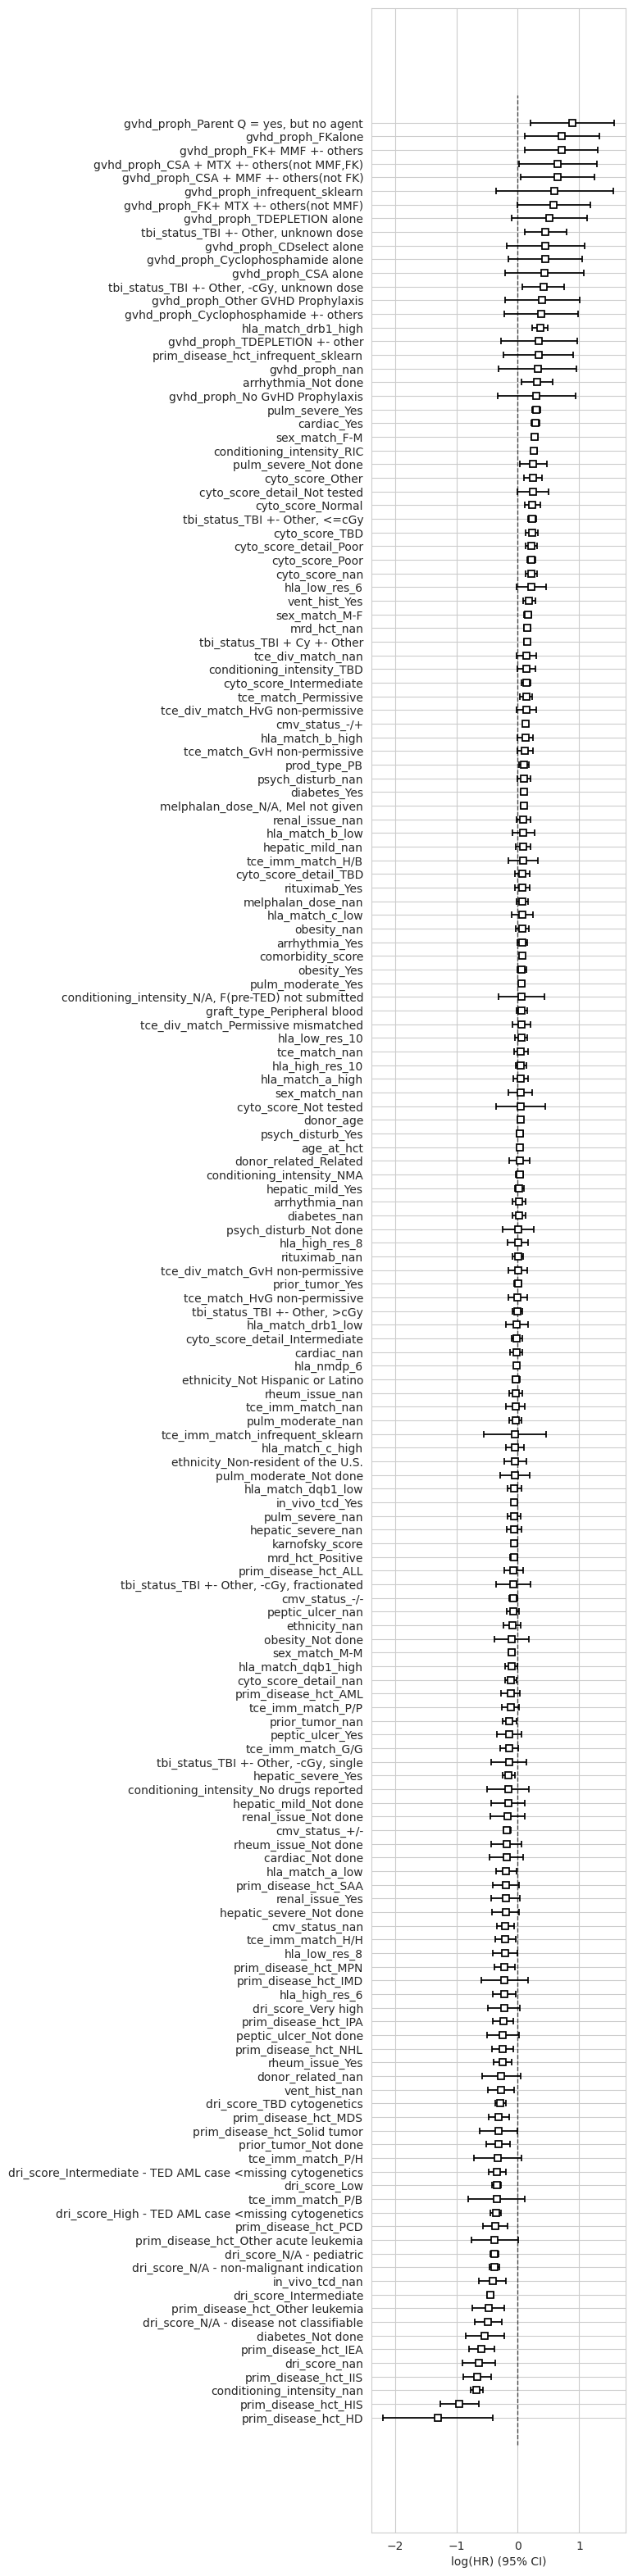

In [29]:
# Plot model coefficients from largest to smallest, with error bars.
# Notice that this model appears quite "noisy".
# Confidence intervals for many coefficients are quite wide,
# and may include zero.
# There are also many coefficients that are 
# close to zero, indicating that feature
# has very little impact.
plt.figure(figsize=(4, 40))
cph.plot()
plt.show()